DEVICE: cuda
IMG_DIR: /home/bootcamp2026_01/images
found: ['00001.png', '0005.jpg', '0008.jpg', '001.jpg', '002.jpg', '003.jpg', '004.jpg', '006.jpg', '007.jpg', '026.jpg', '123.jpg', '12345123231.jpg', '123545.jpg', '20250526153814706001.jpg', '티셔츠프린팅_(1).jpg']
OUT_DIR: /home/bootcamp2026_01/debug_clothes_visual_focus_v2
build_sam2 failed -> OmegaConf instantiate fallback: MissingConfigException("Cannot find primary config 'home/jjs2403/2026_bootcamp_02/models/SAM2.1/weights/sam2.1_hiera_l.yaml'. Check that it's in your config search path.\n\nConfig search path:\n\tprovider=hydra, path=pkg://hydra.conf\n\tprovider=main, path=pkg://sam2\n\tprovider=schema, path=structured://")
SAM2.1 loaded via OmegaConf


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Qwen loaded: /home/jjs2403/2026_bootcamp_02/models/Qwen3-VL-8B-Instruct

image: 00001.png


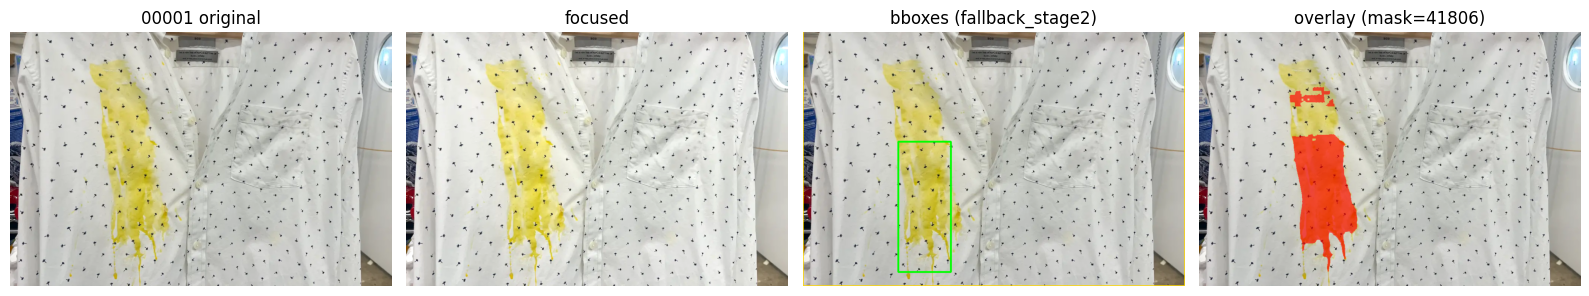


image: 0005.jpg


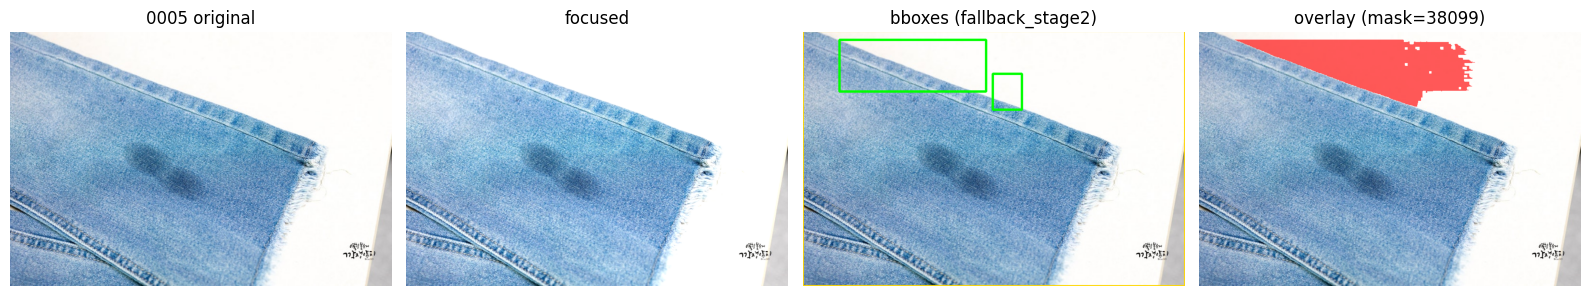


image: 0008.jpg


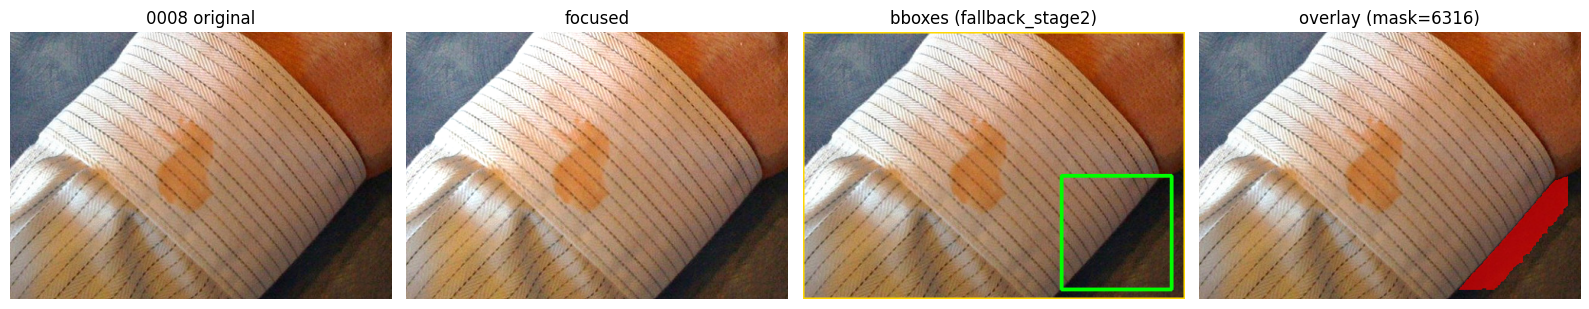


image: 001.jpg


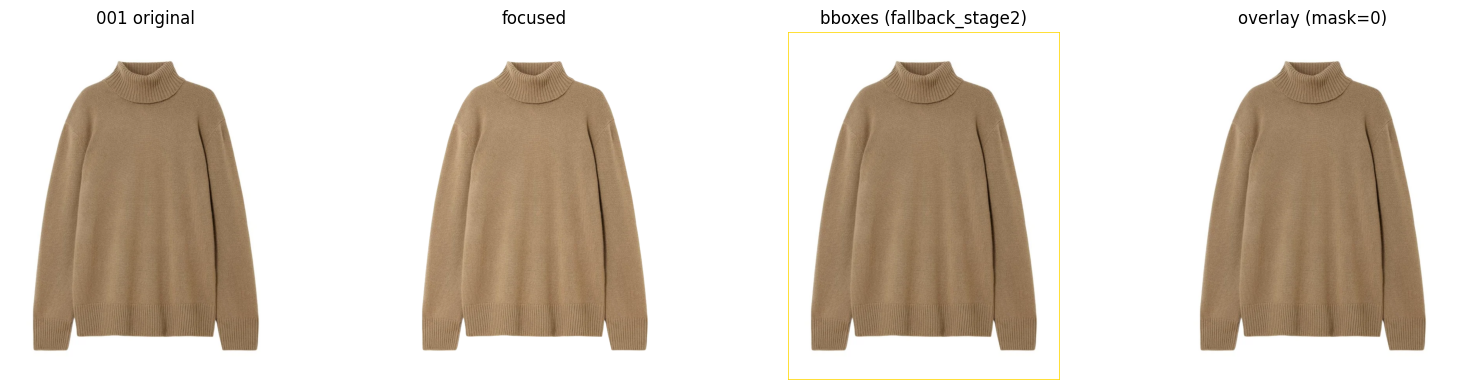


image: 002.jpg


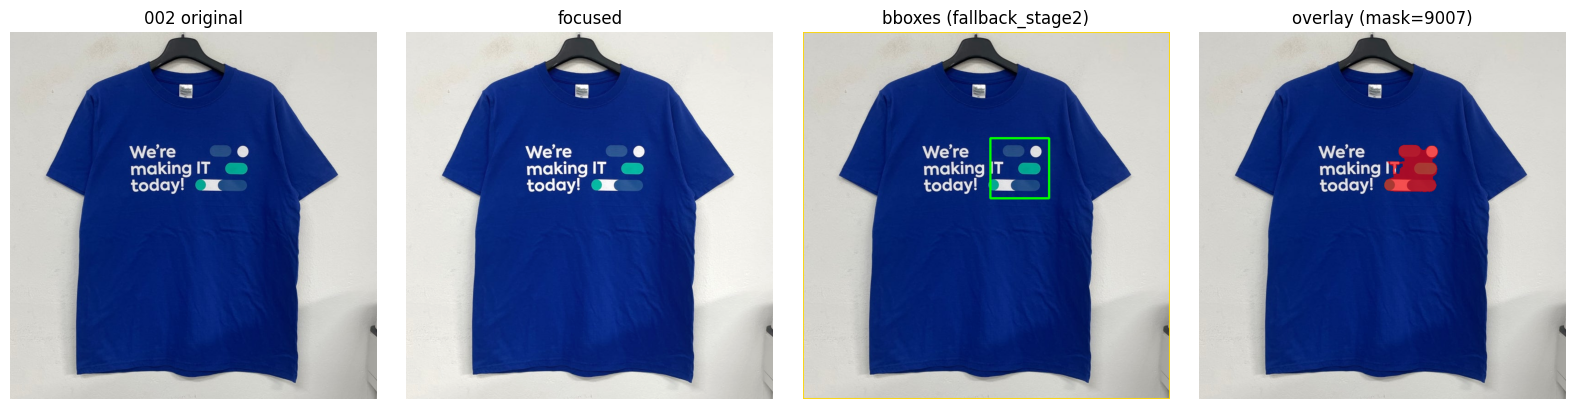


image: 003.jpg


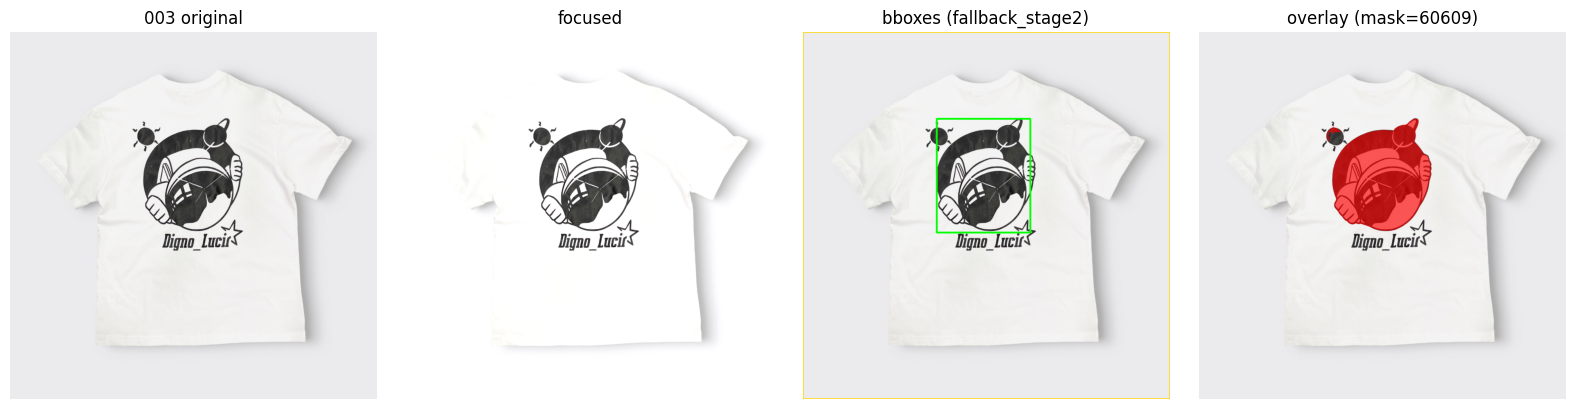


image: 004.jpg


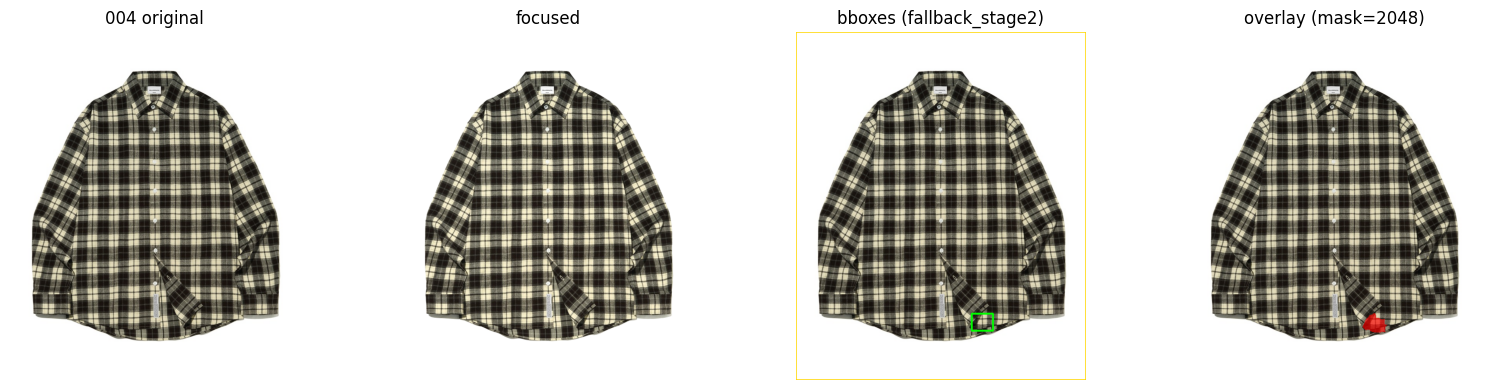


image: 006.jpg


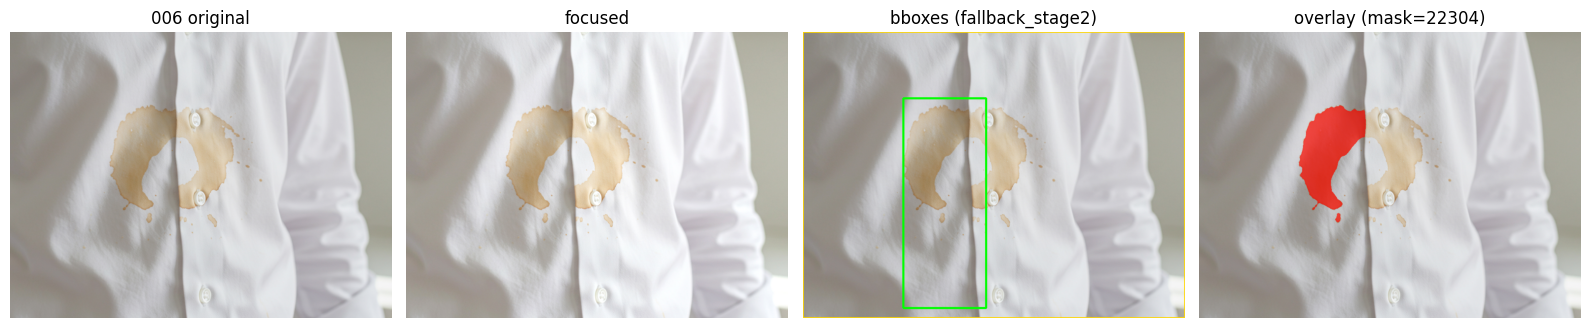


image: 007.jpg


In [ ]:
# ============================================================
# Clothes stain segmentation with 2-Stage Visual Focus Pipeline
# Stage 1: Qwen clothing bbox
# Stage 2: Visual focus + Qwen stain boxes -> SAM2.1
# Fallback: LAB local-diff heatmap
# ============================================================

import os
import re
import json
import warnings
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch

warnings.filterwarnings("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# -------------------------
# 1) Image folder auto-detect
# -------------------------
CAND_IMAGE_DIRS = [Path("/competition/images"), Path("./images"), Path("../images")]
IMG_DIR = next((p for p in CAND_IMAGE_DIRS if p.exists()), None)
assert IMG_DIR is not None, f"images dir not found. candidates={CAND_IMAGE_DIRS}"
print("IMG_DIR:", IMG_DIR.resolve())

# clothes000~005 or clothes001~006
img_paths = []
for i in range(0, 6):
    p = IMG_DIR / f"clothes{i:03d}.jpg"
    if p.exists():
        img_paths.append(p)
if len(img_paths) == 0:
    for i in range(1, 7):
        p = IMG_DIR / f"clothes{i:03d}.jpg"
        if p.exists():
            img_paths.append(p)
if len(img_paths) == 0:
    # Fallback: grab any common image files in the directory
    img_paths = sorted(
        [
            p
            for p in IMG_DIR.iterdir()
            if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
        ]
    )
assert len(img_paths) > 0, f"clothes images not found in {IMG_DIR}"
print("found:", [p.name for p in img_paths])

# Save outputs to current folder
OUT_DIR = Path("./debug_clothes_visual_focus_v2")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR.resolve())

# -------------------------
# 2) SAM2.1 loading (prefer build_sam2)
# -------------------------
import sys

SAM2_CODE = Path("/home/jjs2403/2026_bootcamp_02/models/sam2")
if SAM2_CODE.exists() and str(SAM2_CODE) not in sys.path:
    sys.path.append(str(SAM2_CODE))

from sam2.sam2_image_predictor import SAM2ImagePredictor

SAM2_1_MODEL_PATH = "/home/jjs2403/2026_bootcamp_02/models/SAM2.1/weights/sam2.1_hiera_large.pt"
SAM2_1_MODEL_CFG = "/home/jjs2403/2026_bootcamp_02/models/SAM2.1/weights/sam2.1_hiera_l.yaml"

sam_predictor = None
try:
    from sam2.build_sam import build_sam2

    sam_model = build_sam2(SAM2_1_MODEL_CFG, SAM2_1_MODEL_PATH, device=DEVICE)
    sam_predictor = SAM2ImagePredictor(sam_model)
    print("SAM2.1 loaded via build_sam2")
except Exception as e:
    print("build_sam2 failed -> OmegaConf instantiate fallback:", repr(e))
    from omegaconf import OmegaConf
    from hydra.utils import instantiate

    cfg = OmegaConf.load(SAM2_1_MODEL_CFG)
    state = torch.load(SAM2_1_MODEL_PATH, map_location="cpu")
    sam_model = instantiate(cfg.model, _recursive_=True)
    if isinstance(state, dict) and "model" in state:
        sam_model.load_state_dict(state["model"], strict=False)
    else:
        sam_model.load_state_dict(state, strict=False)
    sam_model = sam_model.to(DEVICE).eval()
    sam_predictor = SAM2ImagePredictor(sam_model)
    print("SAM2.1 loaded via OmegaConf")

# -------------------------
# 3) Qwen loading (use if available)
# -------------------------
USE_QWEN = True
qwen = None
processor = None

try:
    from transformers import AutoProcessor, Qwen3VLForConditionalGeneration

    QWEN_CANDIDATES = [
        "/home/jjs2403/2026_bootcamp_02/models/Qwen3-VL-8B-Instruct",
        "/home/jjs2403/2026_bootcamp_02/models/Qwen2.5-VL-7B-Instruct",
        "/home/bootcamp2026_04/models/Qwen3-VL-8B-Instruct",
        "/home/bootcamp2026_04/models/Qwen2.5-VL-7B-Instruct",
    ]
    QWEN_PATH = next((p for p in map(Path, QWEN_CANDIDATES) if p.exists()), None)
    if QWEN_PATH is None:
        USE_QWEN = False
        print("Qwen model path not found -> fallback only")
    else:
        processor = AutoProcessor.from_pretrained(str(QWEN_PATH), trust_remote_code=True)
        qwen = Qwen3VLForConditionalGeneration.from_pretrained(
            str(QWEN_PATH),
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map="auto",
            trust_remote_code=True,
        ).eval()
        print("Qwen loaded:", QWEN_PATH)
except Exception as e:
    USE_QWEN = False
    print("Qwen load failed -> fallback only:", repr(e))

# -------------------------
# 4) Utils
# -------------------------
MAX_STAIN_BOX_RATIO = 0.30
MAX_WHOLE_IMG_RATIO = 0.70
MAX_CLOTH_MASK_RATIO = 0.50


def clamp_box(box, w, h):
    x1, y1, x2, y2 = map(float, box)
    x1 = int(max(0, min(w - 1, round(x1))))
    y1 = int(max(0, min(h - 1, round(y1))))
    x2 = int(max(0, min(w - 1, round(x2))))
    y2 = int(max(0, min(h - 1, round(y2))))
    if x2 < x1:
        x1, x2 = x2, x1
    if y2 < y1:
        y1, y2 = y2, y1
    return [x1, y1, x2, y2]


def expand_box(box, w, h, pad_ratio=0.02, pad_px=8):
    x1, y1, x2, y2 = box
    pad = max(pad_px, int(pad_ratio * max(1, max(x2 - x1 + 1, y2 - y1 + 1))))
    return clamp_box([x1 - pad, y1 - pad, x2 + pad, y2 + pad], w, h)


def box_area(b):
    return max(1, (b[2] - b[0] + 1) * (b[3] - b[1] + 1))


def intersection_area(a, b):
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])
    if x2 < x1 or y2 < y1:
        return 0
    return (x2 - x1 + 1) * (y2 - y1 + 1)


def clip_box_to_box(b, limit):
    x1 = max(b[0], limit[0])
    y1 = max(b[1], limit[1])
    x2 = min(b[2], limit[2])
    y2 = min(b[3], limit[3])
    if x2 < x1 or y2 < y1:
        return None
    return [x1, y1, x2, y2]


def make_box_mask(h, w, box):
    mask = np.zeros((h, w), dtype=bool)
    x1, y1, x2, y2 = box
    mask[y1 : y2 + 1, x1 : x2 + 1] = True
    return mask


def draw_boxes(img_rgb, boxes, color=(0, 255, 0), thickness=3):
    out = img_rgb.copy()
    for b in boxes:
        x1, y1, x2, y2 = b
        cv2.rectangle(out, (x1, y1), (x2, y2), color, thickness)
    return out


def overlay_mask(img_rgb, mask_bool):
    out = img_rgb.copy()
    m = mask_bool.astype(bool)
    out[m] = (out[m] * 0.35 + np.array([255, 0, 0]) * 0.65).astype(np.uint8)
    return out


def apply_visual_focus(img_rgb, cloth_box, blur_ksize=31, darken=0.45, brighten=1.08):
    h, w = img_rgb.shape[:2]
    x1, y1, x2, y2 = cloth_box

    focus = np.zeros((h, w), dtype=np.uint8)
    focus[y1 : y2 + 1, x1 : x2 + 1] = 255

    k = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1
    blurred = cv2.GaussianBlur(img_rgb, (k, k), 0)

    edge_k = max(3, int(k / 3))
    if edge_k % 2 == 0:
        edge_k += 1
    soft = cv2.GaussianBlur(focus, (edge_k, edge_k), 0).astype(np.float32) / 255.0

    bg = np.clip(blurred * darken, 0, 255).astype(np.uint8)
    fg = np.clip(img_rgb * brighten + 4, 0, 255).astype(np.uint8)

    out = (fg * soft[..., None] + bg * (1.0 - soft[..., None])).astype(np.uint8)
    return out


def shrink_box(box, w, h, margin_ratio=0.05):
    x1, y1, x2, y2 = box
    bw = max(1, x2 - x1 + 1)
    bh = max(1, y2 - y1 + 1)
    mx = int(bw * margin_ratio)
    my = int(bh * margin_ratio)
    nx1 = min(x2, x1 + mx)
    ny1 = min(y2, y1 + my)
    nx2 = max(x1, x2 - mx)
    ny2 = max(y1, y2 - my)
    if nx1 >= nx2 or ny1 >= ny2:
        return box
    return clamp_box([nx1, ny1, nx2, ny2], w, h)


def normalize_map(m, p_low=50.0, p_high=99.5):
    lo = float(np.percentile(m, p_low))
    hi = float(np.percentile(m, p_high))
    if hi <= lo + 1e-6:
        return np.zeros_like(m, dtype=np.float32)
    out = (m - lo) / (hi - lo)
    return np.clip(out, 0.0, 1.0).astype(np.float32)


def is_score_map_informative(score_map, cloth_box=None, min_spread=0.12):
    if cloth_box is None:
        roi = score_map
    else:
        x1, y1, x2, y2 = cloth_box
        roi = score_map[y1 : y2 + 1, x1 : x2 + 1]
    p50 = float(np.percentile(roi, 50))
    p99 = float(np.percentile(roi, 99))
    return (p99 - p50) >= min_spread


def compute_stain_score_map(img_rgb, cloth_box, blur_k=41):
    h, w = img_rgb.shape[:2]
    if cloth_box is None:
        cloth_box = [0, 0, w - 1, h - 1]
    x0, y0, x1, y1 = cloth_box

    roi = img_rgb[y0 : y1 + 1, x0 : x1 + 1]
    stat_box = shrink_box(cloth_box, w, h, margin_ratio=0.05)
    sx0, sy0, sx1, sy1 = stat_box
    stat_roi = img_rgb[sy0 : sy1 + 1, sx0 : sx1 + 1]
    if stat_roi.size == 0:
        stat_roi = roi

    lab_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2LAB).astype(np.float32)
    lab_stat = cv2.cvtColor(stat_roi, cv2.COLOR_RGB2LAB).astype(np.float32)

    l_stat = lab_stat[:, :, 0]
    a_stat = lab_stat[:, :, 1]
    b_stat = lab_stat[:, :, 2]

    l_med = float(np.median(l_stat))
    a_med = float(np.median(a_stat))
    b_med = float(np.median(b_stat))

    l_mad = float(np.median(np.abs(l_stat - l_med))) + 1e-3
    l_chan = lab_roi[:, :, 0]
    a_chan = lab_roi[:, :, 1]
    b_chan = lab_roi[:, :, 2]

    l_score = np.abs(l_chan - l_med) / l_mad
    ab_diff = np.sqrt((a_chan - a_med) ** 2 + (b_chan - b_med) ** 2)
    ab_mad = float(np.median(np.sqrt((a_stat - a_med) ** 2 + (b_stat - b_med) ** 2))) + 1e-3
    ab_score = ab_diff / ab_mad

    k = blur_k if blur_k % 2 == 1 else blur_k + 1
    lb = cv2.medianBlur(l_chan.astype(np.uint8), k).astype(np.float32)
    ab = cv2.medianBlur(a_chan.astype(np.uint8), k).astype(np.float32)
    bb = cv2.medianBlur(b_chan.astype(np.uint8), k).astype(np.float32)
    local = np.abs(l_chan - lb) + 0.6 * np.abs(a_chan - ab) + 0.6 * np.abs(b_chan - bb)

    l_score = normalize_map(l_score, 50, 99.5)
    ab_score = normalize_map(ab_score, 50, 99.5)
    local = normalize_map(local, 50, 99.0)

    score = 0.45 * ab_score + 0.35 * l_score + 0.20 * local

    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY).astype(np.float32)
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx * gx + gy * gy)
    grad_norm = normalize_map(grad, 50, 99.0)
    score = score * (1.0 - 0.5 * grad_norm)
    score = np.clip(score, 0.0, 1.0).astype(np.float32)

    full = np.zeros((h, w), dtype=np.float32)
    full[y0 : y1 + 1, x0 : x1 + 1] = score
    return full


def compute_print_mask(img_rgb, cloth_box, edge_k_ratio=0.04, min_area_ratio=0.003):
    h, w = img_rgb.shape[:2]
    if cloth_box is None:
        cloth_box = [0, 0, w - 1, h - 1]
    x0, y0, x1, y1 = cloth_box

    roi = img_rgb[y0 : y1 + 1, x0 : x1 + 1]
    rh, rw = roi.shape[:2]
    if rh < 12 or rw < 12:
        return np.zeros((h, w), dtype=bool)

    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    v = float(np.median(blur))
    lower = int(max(0, 0.66 * v))
    upper = int(min(255, 1.33 * v))
    edges = cv2.Canny(blur, lower, upper)

    k = max(7, int(min(rw, rh) * edge_k_ratio))
    if k % 2 == 0:
        k += 1
    density = cv2.blur((edges > 0).astype(np.float32), (k, k))
    thr = max(0.08, float(np.percentile(density, 90)))
    dense = (density >= thr).astype(np.uint8) * 255

    dense = cv2.morphologyEx(dense, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=1)
    dense = cv2.morphologyEx(dense, cv2.MORPH_DILATE, np.ones((3, 3), np.uint8), iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(dense, connectivity=8)
    min_area = int(min_area_ratio * (rw * rh))
    mask = np.zeros((rh, rw), dtype=bool)
    for i in range(1, num):
        area = int(stats[i, cv2.CC_STAT_AREA])
        if area < min_area:
            continue
        comp = labels == i
        if density[comp].mean() < 0.10:
            continue
        mask[comp] = True

    full = np.zeros((h, w), dtype=bool)
    full[y0 : y1 + 1, x0 : x1 + 1] = mask
    return full


def filter_boxes_by_score(boxes, score_map, min_mean=0.22):
    if score_map is None or score_map.max() <= 0:
        return boxes
    out = []
    for b in boxes:
        x1, y1, x2, y2 = b
        mean_score = float(score_map[y1 : y2 + 1, x1 : x2 + 1].mean())
        if mean_score >= min_mean:
            out.append(b)
    return out


def filter_boxes_by_print_mask(
    boxes,
    print_mask,
    score_map=None,
    max_ratio=0.55,
    min_keep_score=0.35,
):
    if print_mask is None:
        return boxes
    out = []
    for b in boxes:
        x1, y1, x2, y2 = b
        area = box_area(b)
        if area <= 0:
            continue
        ratio = float(print_mask[y1 : y2 + 1, x1 : x2 + 1].mean())
        if ratio >= max_ratio:
            mean_score = 0.0
            if score_map is not None and score_map.max() > 0:
                mean_score = float(score_map[y1 : y2 + 1, x1 : x2 + 1].mean())
            if mean_score < min_keep_score:
                continue
        out.append(b)
    return out


def expand_stain_boxes(boxes, w, h, cloth_box=None, pad_ratio=0.18, pad_px=8):
    out = []
    for b in boxes:
        expanded = expand_box(b, w, h, pad_ratio=pad_ratio, pad_px=pad_px)
        if cloth_box is not None:
            clipped = clip_box_to_box(expanded, cloth_box)
            out.append(clipped if clipped is not None else b)
        else:
            out.append(expanded)
    return out


def boxes_close(a, b, gap=8):
    return not (
        a[2] + gap < b[0]
        or b[2] + gap < a[0]
        or a[3] + gap < b[1]
        or b[3] + gap < a[1]
    )


def merge_boxes(boxes, iou_thresh=0.12, gap=8):
    if len(boxes) <= 1:
        return boxes
    merged = boxes[:]
    changed = True
    while changed:
        changed = False
        new_boxes = []
        used = [False] * len(merged)
        for i in range(len(merged)):
            if used[i]:
                continue
            a = merged[i]
            used[i] = True
            for j in range(i + 1, len(merged)):
                if used[j]:
                    continue
                b = merged[j]
                inter = intersection_area(a, b)
                union = box_area(a) + box_area(b) - inter
                iou = inter / float(union) if union > 0 else 0.0
                if iou >= iou_thresh or boxes_close(a, b, gap=gap):
                    a = [
                        min(a[0], b[0]),
                        min(a[1], b[1]),
                        max(a[2], b[2]),
                        max(a[3], b[3]),
                    ]
                    used[j] = True
                    changed = True
            new_boxes.append(a)
        merged = new_boxes
    return merged


def expand_boxes_by_score_mask(
    boxes,
    score_map,
    cloth_box=None,
    perc=96.5,
    min_thr=0.25,
    max_area_ratio=0.60,
):
    if score_map is None or score_map.max() <= 0 or len(boxes) == 0:
        return boxes
    h, w = score_map.shape[:2]
    if cloth_box is None:
        x0, y0, x1, y1 = 0, 0, w - 1, h - 1
        cloth_area = h * w
    else:
        x0, y0, x1, y1 = cloth_box
        cloth_area = box_area(cloth_box)

    roi = score_map[y0 : y1 + 1, x0 : x1 + 1]
    thr = max(min_thr, float(np.percentile(roi, perc)))
    mask = (roi >= thr).astype(np.uint8)
    if mask.sum() == 0:
        return boxes

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    out = []
    for b in boxes:
        bx1, by1, bx2, by2 = b
        rx1 = max(0, bx1 - x0)
        ry1 = max(0, by1 - y0)
        rx2 = min((x1 - x0), bx2 - x0)
        ry2 = min((y1 - y0), by2 - y0)
        if rx2 < rx1 or ry2 < ry1:
            out.append(b)
            continue
        sub = labels[ry1 : ry2 + 1, rx1 : rx2 + 1]
        labels_in = sub[sub > 0]
        if labels_in.size == 0:
            out.append(b)
            continue
        vals, counts = np.unique(labels_in, return_counts=True)
        best_label = int(vals[np.argmax(counts)])
        area = int(stats[best_label, cv2.CC_STAT_AREA])
        if area / float(cloth_area) > max_area_ratio:
            out.append(b)
            continue
        cx = int(stats[best_label, cv2.CC_STAT_LEFT])
        cy = int(stats[best_label, cv2.CC_STAT_TOP])
        cw = int(stats[best_label, cv2.CC_STAT_WIDTH])
        ch = int(stats[best_label, cv2.CC_STAT_HEIGHT])
        comp_box = [cx + x0, cy + y0, cx + x0 + cw - 1, cy + y0 + ch - 1]
        merged = [
            min(b[0], comp_box[0]),
            min(b[1], comp_box[1]),
            max(b[2], comp_box[2]),
            max(b[3], comp_box[3]),
        ]
        out.append(clamp_box(merged, w, h))
    return out


def score_map_stats(score_map, cloth_box=None):
    if score_map is None or score_map.max() <= 0:
        return 0.0
    if cloth_box is None:
        roi = score_map
    else:
        x1, y1, x2, y2 = cloth_box
        roi = score_map[y1 : y2 + 1, x1 : x2 + 1]
    return float(np.percentile(roi, 99))


# -------------------------
# 5) Qwen prompts + JSON parsing
# -------------------------

def build_cloth_prompt():
    return (
        "You are a visual grounding assistant.\n"
        "Find the main clothing item/garment in the image.\n"
        "Return ONLY valid JSON in this schema:\n"
        "{\n"
        '  "cloth":[{"bbox_2d":[x1,y1,x2,y2],"score":0.0}],\n'
        '  "note":"short"\n'
        "}\n"
        "Rules:\n"
        "- bbox_2d is pixel coords.\n"
        "- Return ONE main garment (largest, central) if multiple.\n"
        "- Box must be tight around the clothing item.\n"
        "- If not found, return cloth=[]\n"
    )


def build_stain_prompt():
    return (
        "You are a visual grounding assistant.\n"
        "Find stains, spots, or dirt on this clothing.\n"
        "Distinguish between irregular stains (coffee, mud) and regular fabric patterns (stripes, logos).\n"
        "Ignore human skin, hands, background, seams, buttons, tags, and printed text.\n"
        "Return ONLY valid JSON in this schema:\n"
        "{\n"
        '  "stains":[{"bbox_2d":[x1,y1,x2,y2],"score":0.0}],\n'
        '  "note":"short"\n'
        "}\n"
        "Rules:\n"
        "- bbox_2d is pixel coords.\n"
        "- Boxes must be TIGHT around stain region.\n"
        "- If multiple stains, return up to 4 boxes.\n"
        "- If no stain, return stains=[]\n"
    )


def extract_json_any(text):
    if text is None:
        return None
    m = re.search(r"```json\s*(\{.*?\})\s*```", text, flags=re.S)
    if m:
        try:
            return json.loads(m.group(1))
        except Exception:
            pass
    m = re.search(r"(\{.*\})", text, flags=re.S)
    if m:
        blob = m.group(1).strip()
        for k in range(len(blob) - 1, 0, -1):
            if blob[k] == "}":
                try:
                    return json.loads(blob[: k + 1])
                except Exception:
                    continue
    return None


@torch.no_grad()
def qwen_infer_json(img_pil, prompt):
    if not USE_QWEN:
        return {"note": "qwen_disabled"}

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img_pil},
                {"type": "text", "text": prompt},
            ],
        }
    ]

    chat = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[chat], images=[img_pil], return_tensors="pt")
    inputs = {k: (v.to(DEVICE) if hasattr(v, "to") else v) for k, v in inputs.items()}

    out_ids = qwen.generate(**inputs, max_new_tokens=256, do_sample=False, num_beams=1)
    out_text = processor.batch_decode(out_ids, skip_special_tokens=True)[0]

    js = extract_json_any(out_text)
    if not isinstance(js, dict):
        js = {"note": "parse_failed", "raw": out_text[:300]}
    return js


# -------------------------
# 6) Stage 1: clothing bbox detection
# -------------------------

def detect_clothing_bbox(img_pil):
    w, h = img_pil.size
    js = qwen_infer_json(img_pil, build_cloth_prompt())

    boxes = []
    if isinstance(js, dict):
        items = js.get("cloth") or js.get("garments") or js.get("clothing") or []
        if isinstance(items, list):
            for item in items:
                b = item.get("bbox_2d") if isinstance(item, dict) else None
                if isinstance(b, list) and len(b) == 4:
                    boxes.append(clamp_box(b, w, h))

    if boxes:
        boxes.sort(key=box_area, reverse=True)
        return boxes[0], js, "qwen"

    return [0, 0, w - 1, h - 1], js, "full_image"


# -------------------------
# 7) Stage 2: stain detection on focused image
# -------------------------

def detect_stains(img_pil, cloth_box=None):
    if cloth_box is not None:
        x1, y1, x2, y2 = cloth_box
        crop = img_pil.crop((x1, y1, x2 + 1, y2 + 1))
        w, h = crop.size
        js = qwen_infer_json(crop, build_stain_prompt())
    else:
        w, h = img_pil.size
        js = qwen_infer_json(img_pil, build_stain_prompt())

    boxes = []
    if isinstance(js, dict):
        stains = js.get("stains", [])
        if isinstance(stains, list):
            for s in stains[:4]:
                b = s.get("bbox_2d", None) if isinstance(s, dict) else None
                if isinstance(b, list) and len(b) == 4:
                    boxes.append(clamp_box(b, w, h))

    if cloth_box is not None:
        ox, oy = cloth_box[0], cloth_box[1]
        boxes = [[b[0] + ox, b[1] + oy, b[2] + ox, b[3] + oy] for b in boxes]

    return boxes, js


def filter_too_large_boxes(boxes, w, h, max_ratio=MAX_STAIN_BOX_RATIO, cloth_box=None):
    if cloth_box is not None:
        ref_area = box_area(cloth_box)
    else:
        ref_area = w * h
    kept = []
    for b in boxes:
        ar = box_area(b) / float(ref_area)
        if ar <= max_ratio:
            kept.append(b)
    return kept


def filter_boxes_to_cloth(boxes, cloth_box, min_overlap=0.2):
    if cloth_box is None:
        return boxes
    out = []
    for b in boxes:
        inter = intersection_area(b, cloth_box)
        if inter <= 0:
            continue
        if inter / float(box_area(b)) < min_overlap:
            continue
        clipped = clip_box_to_box(b, cloth_box)
        if clipped is not None:
            out.append(clipped)
    return out


def filter_boxes_near_border(boxes, cloth_box, min_area_ratio=0.004, border_ratio=0.03):
    if cloth_box is None:
        return boxes
    cx1, cy1, cx2, cy2 = cloth_box
    cw = max(1, cx2 - cx1 + 1)
    ch = max(1, cy2 - cy1 + 1)
    cloth_area = box_area(cloth_box)
    margin = int(border_ratio * min(cw, ch))
    out = []
    for b in boxes:
        touches = (
            (b[0] - cx1) <= margin
            or (b[1] - cy1) <= margin
            or (cx2 - b[2]) <= margin
            or (cy2 - b[3]) <= margin
        )
        if touches and (box_area(b) / float(cloth_area)) < min_area_ratio:
            continue
        out.append(b)
    return out


# -------------------------
# 8) Fallback bbox: LAB local-diff heatmap (within cloth bbox)
# -------------------------

def fallback_stain_boxes(
    img_rgb,
    cloth_box=None,
    score_map=None,
    topk=4,
    blur_k=41,
    perc=99.2,
    min_area=120,
):
    h, w = img_rgb.shape[:2]

    if cloth_box is None:
        x0, y0, x1, y1 = 0, 0, w - 1, h - 1
    else:
        x0, y0, x1, y1 = cloth_box

    if score_map is None:
        score_map = compute_stain_score_map(img_rgb, cloth_box, blur_k=blur_k)

    roi = score_map[y0 : y1 + 1, x0 : x1 + 1].copy()
    rh, rw = roi.shape[:2]

    # Suppress top strip inside cloth bbox (neck/background boundary)
    roi[: int(0.12 * rh), :] = 0

    percs = [perc, 99.0, 98.5, 98.0]
    comps = []

    for cur_perc in percs:
        thr = np.percentile(roi, cur_perc)
        binm = (roi >= thr).astype(np.uint8) * 255

        binm = cv2.morphologyEx(binm, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
        binm = cv2.morphologyEx(binm, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=1)

        num, labels, stats, _ = cv2.connectedComponentsWithStats(binm, connectivity=8)

        comps = []
        border_margin = int(0.03 * min(rw, rh))
        for i in range(1, num):
            area = int(stats[i, cv2.CC_STAT_AREA])
            if area < min_area:
                continue
            x = int(stats[i, cv2.CC_STAT_LEFT])
            y = int(stats[i, cv2.CC_STAT_TOP])
            bw = int(stats[i, cv2.CC_STAT_WIDTH])
            bh = int(stats[i, cv2.CC_STAT_HEIGHT])
            bx1, by1, bx2, by2 = x, y, x + bw - 1, y + bh - 1

            if (bw * bh) / float(rw * rh) > 0.20:
                continue

            aspect = max(bw / float(bh), bh / float(bw))
            touches_border = (
                bx1 <= border_margin
                or by1 <= border_margin
                or bx2 >= rw - 1 - border_margin
                or by2 >= rh - 1 - border_margin
            )
            if touches_border and area < min_area * 4:
                continue
            if aspect > 6.0 and area < min_area * 6:
                continue

            pad = max(8, int(0.12 * max(bw, bh)))
            bx1 = max(0, bx1 - pad)
            by1 = max(0, by1 - pad)
            bx2 = min(rw - 1, bx2 + pad)
            by2 = min(rh - 1, by2 + pad)

            mean_score = float(roi[by1 : by2 + 1, bx1 : bx2 + 1].mean())
            comps.append((area * (0.6 + mean_score), [bx1 + x0, by1 + y0, bx2 + x0, by2 + y0]))

        if len(comps) > 0:
            break

    comps.sort(key=lambda x: x[0], reverse=True)
    boxes = [b for _, b in comps[:topk]]
    return boxes, score_map


# -------------------------
# 9) SAM2: boxes (+ center point) -> mask
# -------------------------

def pick_best_sam_mask(
    masks,
    scores,
    img_area,
    cloth_box,
    max_img_ratio,
    max_cloth_ratio,
    score_map=None,
    min_mean_score=0.15,
):
    best_mask = None
    best_score = -1e9

    map_informative = False
    if score_map is not None and score_map.max() > 0:
        map_informative = is_score_map_informative(score_map, cloth_box=cloth_box)

    if cloth_box is not None:
        cloth_area = box_area(cloth_box)
        x1, y1, x2, y2 = cloth_box
    else:
        cloth_area = img_area
        x1 = y1 = x2 = y2 = None

    for i in range(masks.shape[0]):
        m = masks[i].astype(bool)
        area = int(m.sum())
        if area <= 0:
            continue
        if area / float(img_area) > max_img_ratio:
            continue

        if cloth_box is not None and cloth_area > 0:
            in_cloth = int(m[y1 : y2 + 1, x1 : x2 + 1].sum())
            if in_cloth / float(cloth_area) > max_cloth_ratio:
                continue

        sam_score = float(scores[i]) if scores is not None else 0.0
        if map_informative:
            mean_score = float(score_map[m].mean())
            if mean_score < min_mean_score:
                continue
            score = 0.65 * sam_score + 0.35 * mean_score
        else:
            score = sam_score

        if score > best_score:
            best_score = score
            best_mask = m

    return best_mask


@torch.no_grad()
def sam_mask_from_boxes(img_rgb, boxes, cloth_box=None, score_map=None):
    h, w = img_rgb.shape[:2]
    img_area = h * w
    sam_predictor.set_image(img_rgb)
    union = np.zeros((h, w), dtype=bool)
    accepted = 0

    for b in boxes:
        x1, y1, x2, y2 = b
        box = np.array(b, dtype=np.float32)

        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0
        pts = np.array([[cx, cy]], dtype=np.float32)
        lbl = np.array([1], dtype=np.int32)

        masks, scores, _ = sam_predictor.predict(
            box=box,
            point_coords=pts,
            point_labels=lbl,
            multimask_output=True,
        )

        best = pick_best_sam_mask(
            masks,
            scores,
            img_area,
            cloth_box,
            max_img_ratio=MAX_WHOLE_IMG_RATIO,
            max_cloth_ratio=MAX_CLOTH_MASK_RATIO,
            score_map=score_map,
            min_mean_score=0.15,
        )

        if best is not None:
            union |= best
            accepted += 1

    if cloth_box is not None:
        union = union & make_box_mask(h, w, cloth_box)

    cloth_ratio = 0.0
    if cloth_box is not None:
        cloth_ratio = union.sum() / float(box_area(cloth_box))
    else:
        cloth_ratio = union.sum() / float(img_area)

    info = {
        "accepted": accepted,
        "cloth_ratio": cloth_ratio,
        "img_ratio": union.sum() / float(img_area),
    }
    return union, info


def postprocess(mask_bool, min_area=200):
    m = (mask_bool.astype(np.uint8) * 255)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    keep = np.zeros_like(m)
    for i in range(1, num):
        if int(stats[i, cv2.CC_STAT_AREA]) >= int(min_area):
            keep[labels == i] = 255
    keep = cv2.morphologyEx(keep, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=1)
    return keep > 0


# -------------------------
# 10) Run + save + visualize
# -------------------------
all_results = []

for p in img_paths:
    print("\n" + "=" * 80)
    print("image:", p.name)

    img_pil = Image.open(p).convert("RGB")
    img_rgb = np.array(img_pil)
    h, w = img_rgb.shape[:2]

    # Stage 1: cloth bbox
    cloth_box, cloth_raw, cloth_source = detect_clothing_bbox(img_pil)
    cloth_box = expand_box(cloth_box, w, h, pad_ratio=0.02, pad_px=8)
    cloth_proc_box = shrink_box(cloth_box, w, h, margin_ratio=0.035)
    cloth_mask = make_box_mask(h, w, cloth_proc_box)

    score_map = compute_stain_score_map(img_rgb, cloth_proc_box, blur_k=41)
    print_mask = compute_print_mask(img_rgb, cloth_proc_box, edge_k_ratio=0.04, min_area_ratio=0.003)
    if print_mask.any():
        score_map[print_mask] *= 0.25
    score_map_informative = is_score_map_informative(score_map, cloth_box=cloth_proc_box)
    score_p99 = score_map_stats(score_map, cloth_proc_box)

    # Visual focus
    focused_rgb = apply_visual_focus(img_rgb, cloth_box, blur_ksize=31, darken=0.45, brighten=1.08)
    focused_pil = Image.fromarray(focused_rgb)

    # Stage 2: stain boxes on focused image
    q_boxes, q_raw = detect_stains(focused_pil, cloth_box=cloth_proc_box)
    q_boxes = filter_too_large_boxes(q_boxes, w, h, cloth_box=cloth_proc_box)
    q_boxes = filter_boxes_to_cloth(q_boxes, cloth_proc_box, min_overlap=0.2)
    if score_map_informative:
        q_boxes = filter_boxes_by_score(q_boxes, score_map, min_mean=0.22)
    q_boxes = filter_boxes_near_border(q_boxes, cloth_proc_box, min_area_ratio=0.004, border_ratio=0.03)
    q_boxes = filter_boxes_by_print_mask(q_boxes, print_mask, score_map=score_map, max_ratio=0.55, min_keep_score=0.35)
    q_boxes = expand_stain_boxes(q_boxes, w, h, cloth_box=cloth_proc_box, pad_ratio=0.18, pad_px=8)
    if score_map_informative:
        q_boxes = expand_boxes_by_score_mask(
            q_boxes,
            score_map,
            cloth_box=cloth_proc_box,
            perc=96.5,
            min_thr=0.25,
            max_area_ratio=0.60,
        )
    q_boxes = merge_boxes(q_boxes, iou_thresh=0.10, gap=10)
    q_boxes = filter_boxes_by_print_mask(q_boxes, print_mask, score_map=score_map, max_ratio=0.60, min_keep_score=0.38)
    q_boxes = filter_too_large_boxes(q_boxes, w, h, cloth_box=cloth_proc_box)

    used = "qwen_stage2"
    diff = None

    if len(q_boxes) == 0:
        used = "fallback_stage2"
        f_boxes, diff = fallback_stain_boxes(
            img_rgb,
            cloth_proc_box,
            score_map=score_map,
            topk=4,
            blur_k=41,
            perc=99.2,
            min_area=120,
        )
        f_boxes = filter_boxes_by_print_mask(f_boxes, print_mask, score_map=score_map, max_ratio=0.55, min_keep_score=0.35)
        f_boxes = expand_stain_boxes(f_boxes, w, h, cloth_box=cloth_proc_box, pad_ratio=0.22, pad_px=10)
        if score_map_informative:
            f_boxes = expand_boxes_by_score_mask(
                f_boxes,
                score_map,
                cloth_box=cloth_proc_box,
                perc=96.0,
                min_thr=0.22,
                max_area_ratio=0.60,
            )
        f_boxes = merge_boxes(f_boxes, iou_thresh=0.10, gap=12)
        f_boxes = filter_boxes_by_print_mask(f_boxes, print_mask, score_map=score_map, max_ratio=0.60, min_keep_score=0.38)
        f_boxes = filter_too_large_boxes(f_boxes, w, h, cloth_box=cloth_proc_box)
        boxes = f_boxes
    else:
        boxes = q_boxes

    mask = np.zeros((h, w), dtype=bool)
    mask_info = {"accepted": 0, "cloth_ratio": 0.0, "img_ratio": 0.0}

    if len(boxes) > 0:
        mask, mask_info = sam_mask_from_boxes(
            img_rgb,
            boxes,
            cloth_box=cloth_proc_box,
            score_map=score_map,
        )
        mask = postprocess(mask, min_area=180)
        mask = mask & cloth_mask
        mask_info["cloth_ratio"] = mask.sum() / float(box_area(cloth_proc_box))
        mask_info["img_ratio"] = mask.sum() / float(h * w)

        # If SAM yields no usable mask, retry with fallback boxes
        if mask_info["accepted"] == 0 or mask.sum() == 0:
            used = "fallback_mask_empty"
            f_boxes, diff = fallback_stain_boxes(
                img_rgb,
                cloth_proc_box,
                score_map=score_map,
                topk=4,
                blur_k=41,
                perc=99.4,
                min_area=150,
            )
            if len(f_boxes) > 0:
                f_boxes = filter_boxes_by_print_mask(f_boxes, print_mask, score_map=score_map, max_ratio=0.55, min_keep_score=0.35)
                f_boxes = expand_stain_boxes(f_boxes, w, h, cloth_box=cloth_proc_box, pad_ratio=0.22, pad_px=10)
                if score_map_informative:
                    f_boxes = expand_boxes_by_score_mask(
                        f_boxes,
                        score_map,
                        cloth_box=cloth_proc_box,
                        perc=96.0,
                        min_thr=0.22,
                        max_area_ratio=0.60,
                    )
                f_boxes = merge_boxes(f_boxes, iou_thresh=0.10, gap=12)
                f_boxes = filter_boxes_by_print_mask(f_boxes, print_mask, score_map=score_map, max_ratio=0.60, min_keep_score=0.38)
                f_boxes = filter_too_large_boxes(f_boxes, w, h, cloth_box=cloth_proc_box)
                boxes = f_boxes
                mask, mask_info = sam_mask_from_boxes(
                    img_rgb,
                    boxes,
                    cloth_box=cloth_proc_box,
                    score_map=score_map,
                )
                mask = postprocess(mask, min_area=220)
                mask = mask & cloth_mask
                mask_info["cloth_ratio"] = mask.sum() / float(box_area(cloth_proc_box))
                mask_info["img_ratio"] = mask.sum() / float(h * w)

        # If mask is too large relative to cloth, treat as failure and retry fallback
        if mask_info["cloth_ratio"] > MAX_CLOTH_MASK_RATIO:
            used = "fallback_mask_large"
            f_boxes, diff = fallback_stain_boxes(
                img_rgb,
                cloth_proc_box,
                score_map=score_map,
                topk=4,
                blur_k=41,
                perc=99.4,
                min_area=150,
            )
            if len(f_boxes) > 0:
                f_boxes = filter_boxes_by_print_mask(f_boxes, print_mask, score_map=score_map, max_ratio=0.55, min_keep_score=0.35)
                f_boxes = expand_stain_boxes(f_boxes, w, h, cloth_box=cloth_proc_box, pad_ratio=0.22, pad_px=10)
                if score_map_informative:
                    f_boxes = expand_boxes_by_score_mask(
                        f_boxes,
                        score_map,
                        cloth_box=cloth_proc_box,
                        perc=96.0,
                        min_thr=0.22,
                        max_area_ratio=0.60,
                    )
                f_boxes = merge_boxes(f_boxes, iou_thresh=0.10, gap=12)
                f_boxes = filter_boxes_by_print_mask(f_boxes, print_mask, score_map=score_map, max_ratio=0.60, min_keep_score=0.38)
                f_boxes = filter_too_large_boxes(f_boxes, w, h, cloth_box=cloth_proc_box)
                boxes = f_boxes
                mask, mask_info = sam_mask_from_boxes(
                    img_rgb,
                    boxes,
                    cloth_box=cloth_proc_box,
                    score_map=score_map,
                )
                mask = postprocess(mask, min_area=220)
                mask = mask & cloth_mask
                mask_info["cloth_ratio"] = mask.sum() / float(box_area(cloth_proc_box))
                mask_info["img_ratio"] = mask.sum() / float(h * w)

        if mask_info["cloth_ratio"] > MAX_CLOTH_MASK_RATIO:
            boxes = []
            mask = np.zeros((h, w), dtype=bool)

    min_mask_area = max(40, int(0.001 * box_area(cloth_proc_box)))
    no_stain = False
    if (len(boxes) == 0 or mask.sum() < min_mask_area) and (
        (not score_map_informative) or (score_p99 < 0.18)
    ):
        no_stain = True
        used = "no_stain"
        boxes = []
        mask = np.zeros((h, w), dtype=bool)

    # Save outputs
    stem = p.stem
    mask_u8 = (mask.astype(np.uint8) * 255)
    cv2.imwrite(str(OUT_DIR / f"{stem}.mask.png"), mask_u8)
    ov = overlay_mask(img_rgb, mask)
    cv2.imwrite(str(OUT_DIR / f"{stem}.overlay.png"), ov[:, :, ::-1])

    bbox_img = img_rgb.copy()
    bbox_img = draw_boxes(bbox_img, [cloth_box], color=(255, 215, 0), thickness=2)
    if len(boxes):
        bbox_img = draw_boxes(bbox_img, boxes, color=(0, 255, 0), thickness=3)
    if no_stain:
        cv2.putText(
            bbox_img,
            "NO STAIN",
            (12, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (255, 0, 0),
            2,
            cv2.LINE_AA,
        )
        cv2.putText(
            ov,
            "NO STAIN",
            (12, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (255, 0, 0),
            2,
            cv2.LINE_AA,
        )
    cv2.imwrite(str(OUT_DIR / f"{stem}.bboxes.png"), bbox_img[:, :, ::-1])

    js = {
        "image": p.name,
        "used": used,
        "boxes": [list(map(int, b)) for b in boxes],
        "cloth_box": list(map(int, cloth_box)),
        "cloth_source": cloth_source,
        "no_stain": bool(no_stain),
        "mask_area": int(mask.sum()),
        "mask_cloth_ratio": float(mask_info.get("cloth_ratio", 0.0)),
        "qwen_note": str(q_raw.get("note", "")) if isinstance(q_raw, dict) else "",
        "qwen_cloth_note": str(cloth_raw.get("note", "")) if isinstance(cloth_raw, dict) else "",
    }
    (OUT_DIR / f"{stem}.json").write_text(json.dumps(js, ensure_ascii=False, indent=2), encoding="utf-8")
    all_results.append(js)

    # Visualize
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title(f"{stem} original")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(focused_rgb)
    plt.title("focused")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(bbox_img)
    plt.title(f"bboxes ({used}){' [no_stain]' if no_stain else ''}")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(ov)
    overlay_title = "overlay (no_stain)" if no_stain else f"overlay (mask={int(mask.sum())})"
    plt.title(overlay_title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

print("\nDONE. saved to:", OUT_DIR.resolve())
print("files: *.mask.png / *.overlay.png / *.bboxes.png / *.json")
